# Speech Emotion Recognition using the RAVDESS

Importing Librosa library(A python package) for extracting important features of the audio like the pitch,tone.

In [1]:
!pip install librosa

/home/aloka/Documents/NLP Project/audio-emotion-model-train/audio-env/bin/pip: 2: exec: /home/aloka/Documents/NLP Project/model-train/audio-env/bin/python3: not found


Loading one audio file from the drive using librosa.
Librosa loads the audio file as a floating point time series.

In [3]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('../archive (4)/Actor_01/03-01-01-01-01-01-01.wav')

Plotting the audio file which was just loaded by librosa using waveplot function of librosa.This Function Plots the amplitude envelope of a waveform.

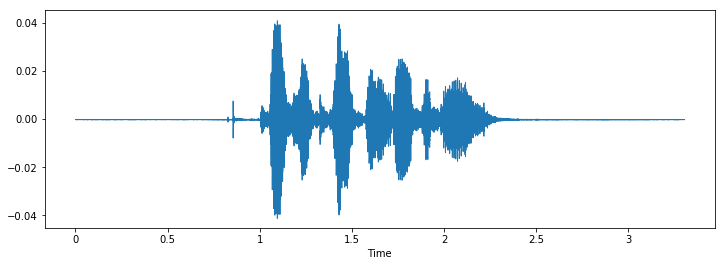

In [6]:
# pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [7]:
import time
import os
import numpy as np
path = '../archive (4)'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 207.87518692016602 seconds ---


In [7]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [8]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2880, 40), (2880,))

In [10]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = 'Ravtess_model'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [12]:
# Loading saved models
import joblib
X = joblib.load('/Ravtess_model/X.joblib')
y = joblib.load('/Ravtess_model/y.joblib')

# Decision Tree Classifier

To make a first attempt in accomplishing this classification task I chose a decision tree:

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
dtree = DecisionTreeClassifier()

In [16]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
predictions = dtree.predict(X_test)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70        65
           1       0.89      0.86      0.87       128
           2       0.82      0.79      0.80       125
           3       0.82      0.81      0.82       126
           4       0.82      0.83      0.82       128
           5       0.73      0.88      0.80       112
           6       0.78      0.78      0.78       146
           7       0.81      0.77      0.79       121

    accuracy                           0.80       951
   macro avg       0.80      0.80      0.80       951
weighted avg       0.81      0.80      0.80       951



# Neural network

In [19]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [20]:
x_traincnn.shape, x_testcnn.shape

((1929, 40, 1), (951, 40, 1))

In [31]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint


model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [27]:
pip install keras

  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
Note: you may need to restart the kernel to use updated packages.


In [32]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 40, 64)            384       
                                                                 
 activation_20 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_15 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 10, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 10, 128)           41088     
                                                                 
 activation_21 (Activation)  (None, 10, 128)           0         
                                                      

In [33]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [34]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
121/121 [==============================] - 1s 4ms/step - loss: 4.8576 - accuracy: 0.1358 - val_loss: 2.6614 - val_accuracy: 0.1314
Epoch 2/200
121/121 [==============================] - 0s 3ms/step - loss: 3.6898 - accuracy: 0.1529 - val_loss: 2.0663 - val_accuracy: 0.1893
Epoch 3/200
121/121 [==============================] - 0s 3ms/step - loss: 3.0604 - accuracy: 0.1700 - val_loss: 2.0733 - val_accuracy: 0.1209
Epoch 4/200
121/121 [==============================] - 0s 3ms/step - loss: 2.7072 - accuracy: 0.1617 - val_loss: 1.9852 - val_accuracy: 0.2261
Epoch 5/200
121/121 [==============================] - 0s 3ms/step - loss: 2.4439 - accuracy: 0.1799 - val_loss: 2.0190 - val_accuracy: 0.2040
Epoch 6/200
121/121 [==============================] - 0s 3ms/step - loss: 2.2504 - accuracy: 0.1949 - val_loss: 1.9113 - val_accuracy: 0.2450
Epoch 7/200
121/121 [==============================] - 0s 3ms/step - loss: 2.1506 - accuracy: 0.2094 - val_loss: 1.9417 - val_accuracy: 0.2271

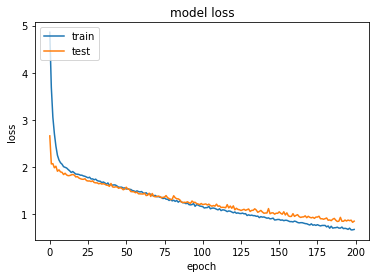

In [35]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

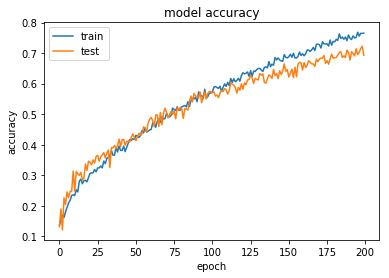

In [36]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# predictions = model.predict(x_testcnn)

predict_x=model.predict(x_testcnn) 
predictions=np.argmax(predict_x,axis=1)


In [49]:
predictions

array([1, 2, 7, 6, 5, 6, 5, 2, 5, 2, 5, 1, 7, 6, 6, 2, 1, 1, 1, 1, 3, 5,
       5, 4, 7, 2, 1, 4, 4, 7, 6, 4, 4, 2, 5, 6, 1, 2, 7, 6, 5, 7, 3, 4,
       5, 1, 7, 1, 4, 1, 6, 3, 5, 4, 7, 4, 5, 4, 3, 1, 5, 7, 3, 5, 3, 1,
       7, 1, 7, 7, 4, 3, 4, 4, 4, 4, 4, 4, 3, 3, 0, 3, 1, 4, 5, 1, 6, 3,
       1, 1, 3, 7, 6, 3, 3, 1, 5, 2, 3, 3, 1, 5, 4, 2, 1, 3, 7, 3, 5, 0,
       7, 4, 2, 5, 5, 6, 1, 3, 6, 4, 3, 5, 4, 6, 6, 4, 2, 5, 5, 1, 5, 6,
       0, 4, 3, 3, 7, 6, 7, 4, 1, 4, 1, 2, 4, 6, 4, 5, 6, 7, 7, 5, 3, 4,
       7, 1, 3, 5, 2, 4, 1, 2, 5, 7, 7, 5, 2, 3, 6, 1, 5, 6, 6, 3, 1, 7,
       7, 0, 7, 7, 1, 1, 6, 6, 4, 7, 1, 5, 7, 3, 5, 1, 2, 5, 2, 6, 3, 2,
       6, 1, 4, 6, 6, 2, 6, 1, 5, 5, 7, 7, 1, 5, 4, 4, 6, 0, 3, 2, 1, 4,
       5, 6, 3, 4, 1, 4, 1, 1, 3, 4, 7, 1, 1, 5, 7, 1, 1, 1, 4, 6, 3, 4,
       5, 6, 7, 7, 5, 4, 3, 1, 4, 7, 2, 1, 5, 6, 7, 1, 0, 7, 5, 1, 6, 1,
       1, 3, 5, 7, 7, 7, 1, 5, 2, 4, 2, 7, 5, 4, 2, 1, 4, 7, 7, 7, 5, 6,
       2, 3, 6, 7, 3, 7, 7, 3, 5, 5, 6, 3, 3, 5, 1,

In [50]:
y_test

array([1, 2, 7, 6, 2, 6, 7, 2, 2, 2, 2, 3, 3, 6, 6, 3, 1, 1, 0, 1, 3, 5,
       5, 7, 7, 4, 1, 4, 4, 3, 6, 4, 7, 2, 5, 5, 1, 7, 6, 6, 0, 4, 3, 7,
       2, 3, 7, 1, 0, 1, 6, 3, 7, 4, 7, 4, 5, 4, 3, 1, 5, 7, 0, 4, 3, 1,
       4, 1, 5, 7, 7, 3, 4, 4, 2, 4, 4, 4, 3, 6, 0, 3, 3, 4, 5, 1, 4, 0,
       1, 1, 5, 6, 6, 3, 5, 1, 6, 7, 3, 1, 1, 4, 4, 2, 1, 3, 7, 3, 5, 0,
       6, 4, 6, 5, 5, 4, 1, 2, 6, 4, 3, 5, 4, 6, 6, 4, 2, 3, 3, 1, 5, 6,
       0, 4, 2, 3, 6, 6, 7, 4, 1, 4, 0, 2, 4, 6, 4, 6, 1, 7, 7, 2, 2, 4,
       7, 1, 3, 5, 2, 4, 1, 7, 5, 7, 7, 2, 1, 3, 6, 1, 5, 6, 3, 2, 1, 7,
       3, 0, 7, 7, 1, 0, 6, 6, 2, 7, 0, 5, 7, 6, 2, 3, 2, 5, 2, 6, 6, 2,
       1, 1, 4, 6, 6, 2, 6, 0, 5, 5, 3, 7, 6, 0, 4, 4, 6, 0, 6, 2, 1, 4,
       5, 6, 2, 4, 1, 7, 1, 6, 1, 4, 7, 0, 1, 6, 7, 1, 1, 0, 6, 6, 3, 4,
       5, 6, 6, 7, 6, 4, 0, 1, 6, 6, 6, 1, 7, 6, 7, 1, 0, 7, 2, 1, 0, 1,
       1, 1, 5, 7, 7, 7, 1, 1, 2, 4, 2, 7, 5, 4, 2, 1, 4, 2, 7, 7, 4, 6,
       3, 5, 6, 3, 0, 3, 5, 3, 2, 2, 6, 3, 2, 5, 1,

In [51]:
new_Ytest = y_test.astype(int)

In [52]:
new_Ytest

array([1, 2, 7, 6, 2, 6, 7, 2, 2, 2, 2, 3, 3, 6, 6, 3, 1, 1, 0, 1, 3, 5,
       5, 7, 7, 4, 1, 4, 4, 3, 6, 4, 7, 2, 5, 5, 1, 7, 6, 6, 0, 4, 3, 7,
       2, 3, 7, 1, 0, 1, 6, 3, 7, 4, 7, 4, 5, 4, 3, 1, 5, 7, 0, 4, 3, 1,
       4, 1, 5, 7, 7, 3, 4, 4, 2, 4, 4, 4, 3, 6, 0, 3, 3, 4, 5, 1, 4, 0,
       1, 1, 5, 6, 6, 3, 5, 1, 6, 7, 3, 1, 1, 4, 4, 2, 1, 3, 7, 3, 5, 0,
       6, 4, 6, 5, 5, 4, 1, 2, 6, 4, 3, 5, 4, 6, 6, 4, 2, 3, 3, 1, 5, 6,
       0, 4, 2, 3, 6, 6, 7, 4, 1, 4, 0, 2, 4, 6, 4, 6, 1, 7, 7, 2, 2, 4,
       7, 1, 3, 5, 2, 4, 1, 7, 5, 7, 7, 2, 1, 3, 6, 1, 5, 6, 3, 2, 1, 7,
       3, 0, 7, 7, 1, 0, 6, 6, 2, 7, 0, 5, 7, 6, 2, 3, 2, 5, 2, 6, 6, 2,
       1, 1, 4, 6, 6, 2, 6, 0, 5, 5, 3, 7, 6, 0, 4, 4, 6, 0, 6, 2, 1, 4,
       5, 6, 2, 4, 1, 7, 1, 6, 1, 4, 7, 0, 1, 6, 7, 1, 1, 0, 6, 6, 3, 4,
       5, 6, 6, 7, 6, 4, 0, 1, 6, 6, 6, 1, 7, 6, 7, 1, 0, 7, 2, 1, 0, 1,
       1, 1, 5, 7, 7, 7, 1, 1, 2, 4, 2, 7, 5, 4, 2, 1, 4, 2, 7, 7, 4, 6,
       3, 5, 6, 3, 0, 3, 5, 3, 2, 2, 6, 3, 2, 5, 1,

In [53]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.31      0.45        65
           1       0.65      0.91      0.76       128
           2       0.71      0.55      0.62       125
           3       0.63      0.60      0.62       126
           4       0.79      0.84      0.82       128
           5       0.59      0.86      0.70       112
           6       0.81      0.61      0.70       146
           7       0.69      0.70      0.69       121

    accuracy                           0.69       951
   macro avg       0.72      0.67      0.67       951
weighted avg       0.71      0.69      0.68       951



In [54]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[ 20  24   1  11   3   5   1   0]
 [  0 116   2   6   0   2   2   0]
 [  0   4  69  10   8  23   2   9]
 [  1  20   2  76   3  10   3  11]
 [  0   0   2   2 108   5   7   4]
 [  0   2   4   4   0  96   3   3]
 [  2  10   5   9   7  12  89  12]
 [  0   2  12   2   8   9   3  85]]


In [55]:
model.save('testing10_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [56]:
new_model=keras.models.load_model('testing10_model.h5')
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 40, 64)            384       
                                                                 
 activation_20 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_15 (Dropout)        (None, 40, 64)            0         
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 10, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 10, 128)           41088     
                                                                 
 activation_21 (Activation)  (None, 10, 128)           0         
                                                      

In [57]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

30/30 [==============================] - 0s 1ms/step - loss: 0.8544 - accuracy: 0.6930
Restored model, accuracy: 69.30%
